# In this notebook a Q learner with dyna and a custom predictor will be trained and evaluated. The Q learner recommends when to buy or sell shares of one particular stock, and in which quantity (in fact it determines the desired fraction of shares in the total portfolio value).

In [1]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error
from multiprocessing import Pool
import pickle

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

import recommender.simulator as sim
from utils.analysis import value_eval
from recommender.agent_predictor import AgentPredictor
from functools import partial
from sklearn.externals import joblib

Populating the interactive namespace from numpy and matplotlib


In [2]:
NUM_THREADS = 1
LOOKBACK = -1
STARTING_DAYS_AHEAD = 252
POSSIBLE_FRACTIONS = [0.0, 1.0]
DYNA = 20
BASE_DAYS = 112

# Get the data
SYMBOL = 'SPY'
total_data_train_df = pd.read_pickle('../../data/data_train_val_df.pkl').stack(level='feature')
data_train_df = total_data_train_df[SYMBOL].unstack()
total_data_test_df = pd.read_pickle('../../data/data_test_df.pkl').stack(level='feature')
data_test_df = total_data_test_df[SYMBOL].unstack()
if LOOKBACK == -1:
    total_data_in_df = total_data_train_df
    data_in_df = data_train_df
else:
    data_in_df = data_train_df.iloc[-LOOKBACK:]
    total_data_in_df = total_data_train_df.loc[data_in_df.index[0]:]
    
# Crop the final days of the test set as a workaround to make dyna work 
# (the env, only has the market calendar up to a certain time)
data_test_df = data_test_df.iloc[:-DYNA]
total_data_test_df = total_data_test_df.loc[:data_test_df.index[-1]]

# Create many agents
index = np.arange(NUM_THREADS).tolist()
env, num_states, num_actions = sim.initialize_env(total_data_in_df, 
                                                  SYMBOL, 
                                                  starting_days_ahead=STARTING_DAYS_AHEAD,
                                                  possible_fractions=POSSIBLE_FRACTIONS)

estimator_close = joblib.load('../../data/best_predictor.pkl')
estimator_volume = joblib.load('../../data/best_volume_predictor.pkl')

agents = [AgentPredictor(num_states=num_states, 
                         num_actions=num_actions, 
                         random_actions_rate=0.98, 
                         random_actions_decrease=0.999,
                         dyna_iterations=DYNA,
                         name='Agent_{}'.format(i),
                         estimator_close=estimator_close,
                         estimator_volume=estimator_volume,
                         env=env,
                         prediction_window=BASE_DAYS) for i in index]

In [3]:
def show_results(results_list, data_in_df, graph=False):
    for values in results_list:
        total_value = values.sum(axis=1)
        print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(total_value))))
        print('-'*100)
        initial_date = total_value.index[0]
        compare_results = data_in_df.loc[initial_date:, 'Close'].copy()
        compare_results.name = SYMBOL
        compare_results_df = pd.DataFrame(compare_results)
        compare_results_df['portfolio'] = total_value
        std_comp_df = compare_results_df / compare_results_df.iloc[0]
        if graph:
            plt.figure()
            std_comp_df.plot()

## Let's show the symbols data, to see how good the recommender has to be.

In [4]:
print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(data_in_df['Close'].iloc[STARTING_DAYS_AHEAD:]))))

Sharpe ratio: 0.4566770027925799
Cum. Ret.: 3.304502617801047
AVG_DRET: 0.0003519913231219332
STD_DRET: 0.012235538451970583
Final value: 205.54


In [5]:
# Simulate (with new envs, each time)
n_epochs = 4

for i in range(n_epochs):
    tic = time()
    env.reset(STARTING_DAYS_AHEAD)
    results_list = sim.simulate_period(total_data_in_df, 
                                       SYMBOL,
                                       agents[0],
                                       starting_days_ahead=STARTING_DAYS_AHEAD,
                                       possible_fractions=POSSIBLE_FRACTIONS,
                                       verbose=False,
                                       other_env=env)
    toc = time()
    print('Epoch: {}'.format(i))
    print('Elapsed time: {} seconds.'.format((toc-tic)))
    print('Random Actions Rate: {}'.format(agents[0].random_actions_rate))
    show_results([results_list], data_in_df)

Starting simulation for agent: Agent_0. 5268 days of simulation to go.
Date 2014-12-22 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 8.802375793457031s.  Value: 42308.33999999999...Epoch: 0
Elapsed time: 5434.664809465408 seconds.
Random Actions Rate: 0.005042577271024555
Sharpe ratio: 0.6348130535351261
Cum. Ret.: 3.2562089999999992
AVG_DRET: 0.0003039301179884733
STD_DRET: 0.007600254944305657
Final value: 42562.08999999999
----------------------------------------------------------------------------------------------------
Starting simulation for agent: Agent_0. 5268 days of simulation to go.
Date 2014-12-22 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 9.082656621932983s.  Value: 28282.389999999992..Epoch: 1
Elapsed time: 5295.369950771332 seconds.
Random Actions Rate: 2.5946515851279002e-05
Sharpe ratio: 0.6479349214106876
Cum. Ret.: 1.8452389999999994
AVG_DRET: 0.00021186369120801266
STD_DRET: 0.005190693882282268
Final value: 28452.389999999992
---------------

Starting simulation for agent: Agent_0. 5268 days of simulation to go.
Date 2014-12-22 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.37877321243286133s.  Value: 35438.31999999997..Sharpe ratio: 1.0037137587999854
Cum. Ret.: 2.565081999999997
AVG_DRET: 0.00024894476075261224
STD_DRET: 0.003937253552833699
Final value: 35650.81999999997
----------------------------------------------------------------------------------------------------


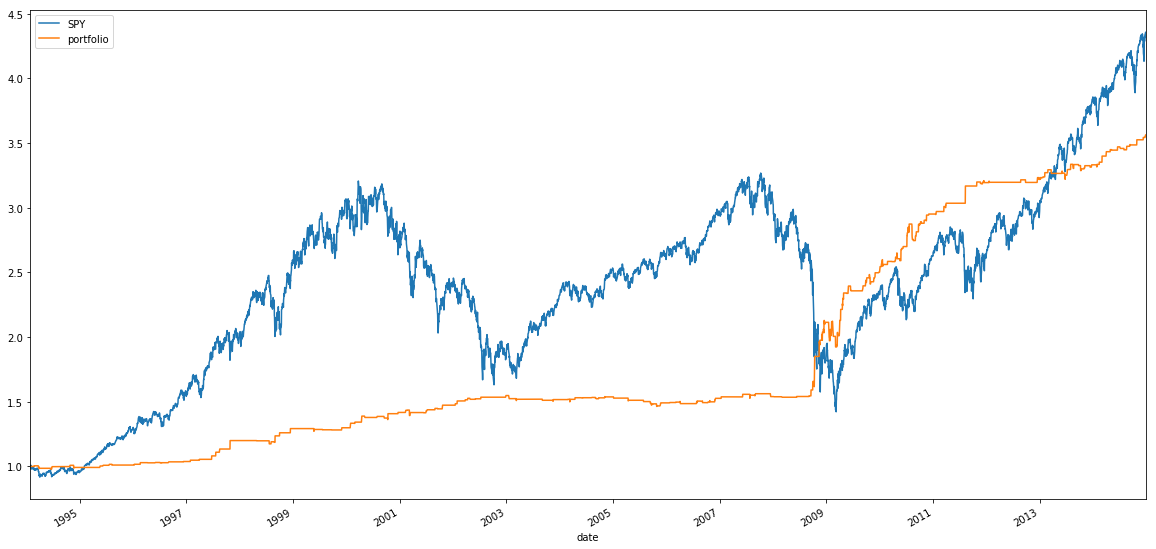

In [6]:
env.reset(STARTING_DAYS_AHEAD)
results_list = sim.simulate_period(total_data_in_df, 
                                   SYMBOL, agents[0], 
                                   learn=False, 
                                   starting_days_ahead=STARTING_DAYS_AHEAD,
                                   possible_fractions=POSSIBLE_FRACTIONS,
                                   other_env=env)
show_results([results_list], data_in_df, graph=True)

In [7]:
import pickle
with open('../../data/dyna_q_with_predictor.pkl', 'wb') as best_agent:
    pickle.dump(agents[0], best_agent)

## Let's run the trained agent, with the test set

### First a non-learning test: this scenario would be worse than what is possible (in fact, the q-learner can learn from past samples in the test set without compromising the causality).

Starting simulation for agent: Agent_0. 372 days of simulation to go.
Date 2016-12-01 00:00:00 (simulating until 2016-12-01 00:00:00).  Time: 0.26997852325439453s.  Value: 9702.590000000002.Epoch: 3
Elapsed time: 8.51533818244934 seconds.
Random Actions Rate: 6.869609028782328e-10
Sharpe ratio: -0.33503797163532956
Cum. Ret.: -0.029740999999999795
AVG_DRET: -7.525648850114656e-05
STD_DRET: 0.0035657442434867542
Final value: 9702.590000000002
----------------------------------------------------------------------------------------------------


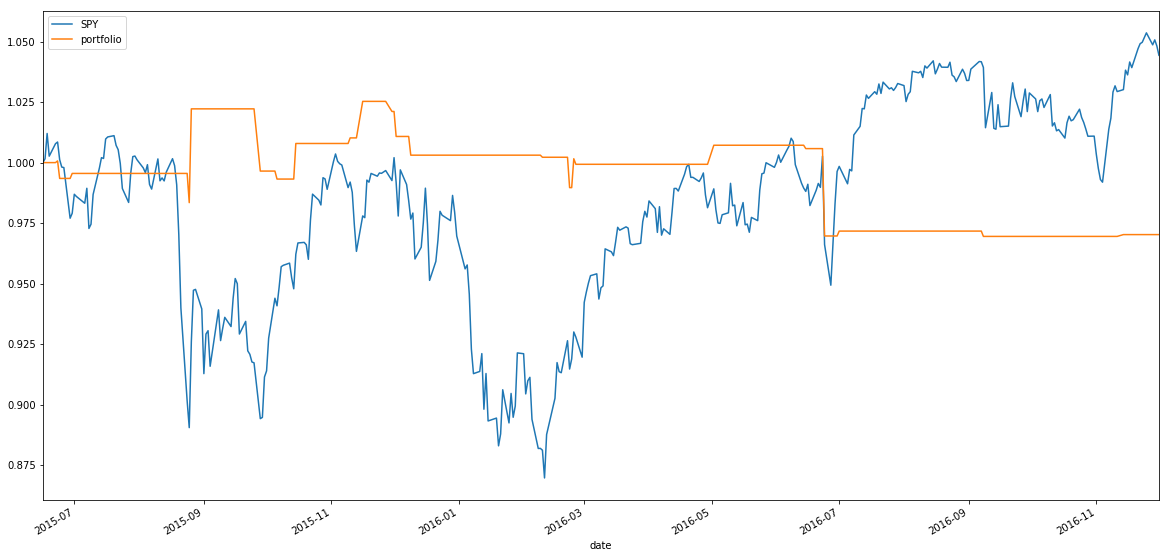

In [8]:
TEST_DAYS_AHEAD = 112

env.set_test_data(total_data_test_df, TEST_DAYS_AHEAD)
tic = time()
results_list = sim.simulate_period(total_data_test_df, 
                                    SYMBOL,
                                    agents[0],
                                    learn=False,
                                    starting_days_ahead=TEST_DAYS_AHEAD,
                                    possible_fractions=POSSIBLE_FRACTIONS,
                                    verbose=False,
                                    other_env=env)
toc = time()
print('Epoch: {}'.format(i))
print('Elapsed time: {} seconds.'.format((toc-tic)))
print('Random Actions Rate: {}'.format(agents[0].random_actions_rate))
show_results([results_list], data_test_df, graph=True)

### And now a "realistic" test, in which the learner continues to learn from past samples in the test set (it even makes some random moves, though very few).

Starting simulation for agent: Agent_0. 372 days of simulation to go.
Date 2016-12-01 00:00:00 (simulating until 2016-12-01 00:00:00).  Time: 8.636018991470337s.  Value: 9229.109999999995.Epoch: 3
Elapsed time: 375.830899477005 seconds.
Random Actions Rate: 4.739452254586605e-10
Sharpe ratio: -0.8531759696425502
Cum. Ret.: -0.07708900000000052
AVG_DRET: -0.00020922152313458637
STD_DRET: 0.0038928530959551925
Final value: 9229.109999999995
----------------------------------------------------------------------------------------------------


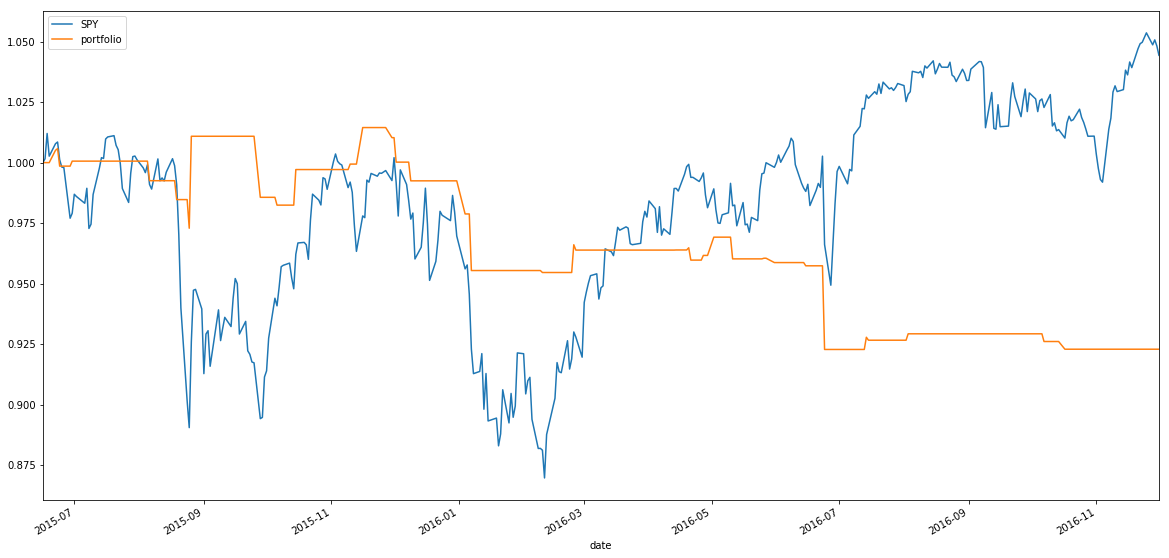

In [9]:
env.set_test_data(total_data_test_df, TEST_DAYS_AHEAD)
tic = time()
results_list = sim.simulate_period(total_data_test_df, 
                                    SYMBOL,
                                    agents[0],
                                    learn=True,
                                    starting_days_ahead=TEST_DAYS_AHEAD,
                                    possible_fractions=POSSIBLE_FRACTIONS,
                                    verbose=False,
                                    other_env=env)
toc = time()
print('Epoch: {}'.format(i))
print('Elapsed time: {} seconds.'.format((toc-tic)))
print('Random Actions Rate: {}'.format(agents[0].random_actions_rate))
show_results([results_list], data_test_df, graph=True)

## What are the metrics for "holding the position"?

In [10]:
print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(data_test_df['Close'].iloc[TEST_DAYS_AHEAD:]))))

Sharpe ratio: 0.2930367522823553
Cum. Ret.: 0.05002151977428149
AVG_DRET: 0.00017808251973497314
STD_DRET: 0.009647159744914929
Final value: 219.57


## Conclusion: 